<a href="https://colab.research.google.com/github/violetaElCactus/predictGames/blob/main/Metacritic_Inteligencia_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerías

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

print("Tensorflow: " + tf.__version__)

Tensorflow: 2.5.0


#Importar los datos

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#data_juegos = pd.read_csv("drive/My Drive/Colab Notebooks/metacritic_game_info.csv")
data_comentarios = pd.read_csv("drive/My Drive/Colab Notebooks/metacritic_game_user_comments.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Información juegos

In [4]:
#data_juegos.head(10)

##Información comentarios

In [5]:
data_comentarios.head(10)

,Unnamed: 0,Title,Platform,Userscore,Comment,Username
0,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus
1,1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin
2,2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody
3,3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman
4,4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA
5,5,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I think it's funny that you have Zelda haters ...,joei1382
6,6,The Legend of Zelda: Ocarina of Time,Nintendo64,9,I played A Link To The Past so many times in m...,Corvix
7,7,The Legend of Zelda: Ocarina of Time,Nintendo64,10,The Legend of Zelda: Ocarina of Time is withou...,pittsburghboy91
8,8,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"This review contains spoilers, cli...",Nosidda89
9,9,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm not kidding when I say that this is the on...,Regeneration13


                      0     1     2     3   ...     7      8      9       10
Number of reviews  20120  7318  5983  7118  ...  17052  30271  53489  112531

[1 rows x 11 columns]
Mean score:  7.6183081381632


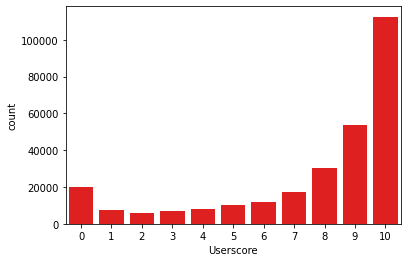

In [6]:
import seaborn as sns

temp=pd.DataFrame(data_comentarios.Userscore.value_counts())
temp.sort_index(inplace=True)
temp.columns=['Number of reviews']
clrs=['red' if (x > 5000) else 'lightcoral' for x in temp['Number of reviews'] ] #highlight bars
sns.countplot(data=data_comentarios,x='Userscore',palette=clrs) 
print(temp.T)
print('Mean score: ', data_comentarios.Userscore.mean())

In [7]:
data_comentarios = data_comentarios[data_comentarios['Comment'].str.len() > 280] #Comentario más largo que un Tweet.


In [8]:
data_comentarios = data_comentarios[data_comentarios['Comment'].map(lambda x: x.isascii())]


In [9]:
data_comentarios["Comment"] = data_comentarios["Comment"].str.lower()


In [10]:
df1 = data_comentarios.iloc[:60000]

In [11]:
len(df1)

60000

In [12]:
df1.drop(['Unnamed: 0','Username','Title','Platform'], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
df1.head(10)


,Userscore,Comment
2,10,anyone who gives the masterpiece below a 7 or ...
3,10,i'm one of those people who think that this is...
4,10,this game is the highest rated game on metacr...
5,10,i think it's funny that you have zelda haters ...
7,10,the legend of zelda: ocarina of time is withou...
8,10,"this review contains spoilers, cli..."
9,10,i'm not kidding when i say that this is the on...
10,10,"essentially one of the best games of all time,..."
11,10,this is the perfect game ! no doubt. the gamep...
16,10,"amazing game in every aspect, i just want to ..."


#Dividir los datos en entrenamiento, validación y prueba




In [14]:
train, validate, test = np.split(df1.sample(frac=1), [int(.7*len(df1)), int(.8*len(df1))])


In [15]:
train_comments = train['Comment']
train_labels = train['Userscore']
validate_comments = validate['Comment']
validate_labels = validate['Userscore']
test_comments = test['Comment']
test_labels = test['Userscore']

#Tokenizer


In [16]:
import keras
from keras.preprocessing.text import Tokenizer


In [17]:
vocab_size = 12000
tokenize = Tokenizer(num_words=vocab_size, char_level=False)
tokenize.fit_on_texts(df1['Comment'])

In [18]:
matrix = tokenize.texts_to_matrix(train_comments, mode = 'binary')

In [19]:
matrixVal = tokenize.texts_to_matrix(validate_comments, mode = 'binary')

In [20]:
matrixTest = tokenize.texts_to_matrix(test_comments, mode = 'binary')

#Modelo

In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers

In [22]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience= 3, verbose= 1)

In [22]:
#y_train_vec = to_categorical(train_labels, num_classes=11)
#y_validate_vec = to_categorical(validate_labels,num_classes=11)
#y_test_vec = to_categorical(test_labels,num_classes=11)

In [23]:
train_lab_sp = np.array(train_labels)
val_lab_sp = np.array(validate_labels)
test_lab_sp = np.array(test_labels)

In [24]:
modelMtx = models.Sequential()
modelMtx.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12000,)))
modelMtx.add(layers.Dense(16,activation='relu'))
modelMtx.add(layers.Dense(16,activation='relu'))
modelMtx.add(layers.Dense(11, activation='softmax'))
modelMtx.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
history = modelMtx.fit(matrix, train_lab_sp, epochs=20, validation_data=(matrixVal,val_lab_sp), callbacks= [es])

Epoch 1/20
1313/1313 [==============================] - 11s 8ms/step - loss: 1.4630 - accuracy: 0.5063 - mae: 8.0471 - val_loss: 1.3450 - val_accuracy: 0.5428 - val_mae: 8.0252
Epoch 2/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.2866 - accuracy: 0.5601 - mae: 8.0471 - val_loss: 1.3308 - val_accuracy: 0.5435 - val_mae: 8.0252
Epoch 3/20
1313/1313 [==============================] - 9s 7ms/step - loss: 1.2507 - accuracy: 0.5758 - mae: 8.0471 - val_loss: 1.3484 - val_accuracy: 0.5467 - val_mae: 8.0252
Epoch 4/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.2301 - accuracy: 0.5883 - mae: 8.0471 - val_loss: 1.3698 - val_accuracy: 0.5392 - val_mae: 8.0252
Epoch 5/20
1313/1313 [==============================] - 9s 7ms/step - loss: 1.2113 - accuracy: 0.5990 - mae: 8.0471 - val_loss: 1.4093 - val_accuracy: 0.5448 - val_mae: 8.0252
Epoch 6/20
1313/1313 [==============================] - 9s 7ms/step - loss: 1.1913 - accuracy: 0.6105 - mae: 8.0471 - v

#Evaluación del modelo


In [26]:
m = modelMtx.evaluate(matrixTest, test_lab_sp)

375/375 [==============================] - 2s 4ms/step - loss: 1.4166 - accuracy: 0.5490 - mae: 8.0165


In [28]:
m

[1.4166456460952759, 0.5490000247955322, 8.016522407531738]

#Prueba

In [27]:
predictionsMtx = modelMtx.predict(matrixTest)

In [78]:
np.argmax(predictionsMtx[2])


6

In [79]:
test_labels.iloc[2]

6

In [80]:
test_comments.iloc[2]

' the port is horrible. graphics look horrible when not driving around (then the game actually looks great) in your car that loses grip at every corner. euphoria is really fun, but not long lasting fun. the controls are quite horrible at times, the main character is boring, npcs are luckily much better made, quite a few missions are just tedious and the cellphone and "friends" are retarded. the port is horrible. graphics look horrible when not driving around (then the game actually looks great) in your car that loses grip at every corner. euphoria is really fun, but not long lasting fun. the controls are quite horrible at times, the main character is boring, npcs are luckily much better made, quite a few missions are just tedious and the cellphone and "friends" are retarded. i have no interest in playing mini-games, ever. the story would be good, if only the missions weren\'t so shitty that you often forgot why you were even doing them. but, it was fun at quite a few times, and once yo

In [55]:
suma = 0
for i in range(len(predictionsMtx)):
  suma += abs(np.argmax(predictionsMtx[i]) - test_labels.iloc[i])
error = suma/len(predictionsMtx)
print(error)  

1.047
